Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 10 input images and 10 annotated images.
Processing image 1/10
Processing image 2/10
Processing image 3/10
Processing image 4/10
Processing image 5/10
Processing image 6/10
Processing image 7/10
Processing image 8/10
Processing image 9/10
Processing image 10/10

Individual Image Metrics:
Image 1: Dice=0.2325, IoU=0.1315
Image 2: Dice=0.4949, IoU=0.3289
Image 3: Dice=0.6218, IoU=0.4512
Image 4: Dice=0.0753, IoU=0.0391
Image 5: Dice=0.5106, IoU=0.3428
Image 6: Dice=0.4587, IoU=0.2976
Image 7: Dice=0.6636, IoU=0.4965
Image 8: Dice=0.4529, IoU=0.2927
Image 9: Dice=0.6150, IoU=0.4440
Image 10: Dice=0.3051, IoU=0.1800

Mean Dice Coefficient: 0.4430
Standard Deviation of Dice Coefficient: 0.1779
Mean IoU Value: 0.3004
Standard Deviation of IoU Value: 0.1399
Finished processing all images and calculating Dice and IoU coefficients.

Image with the lowest Dice C

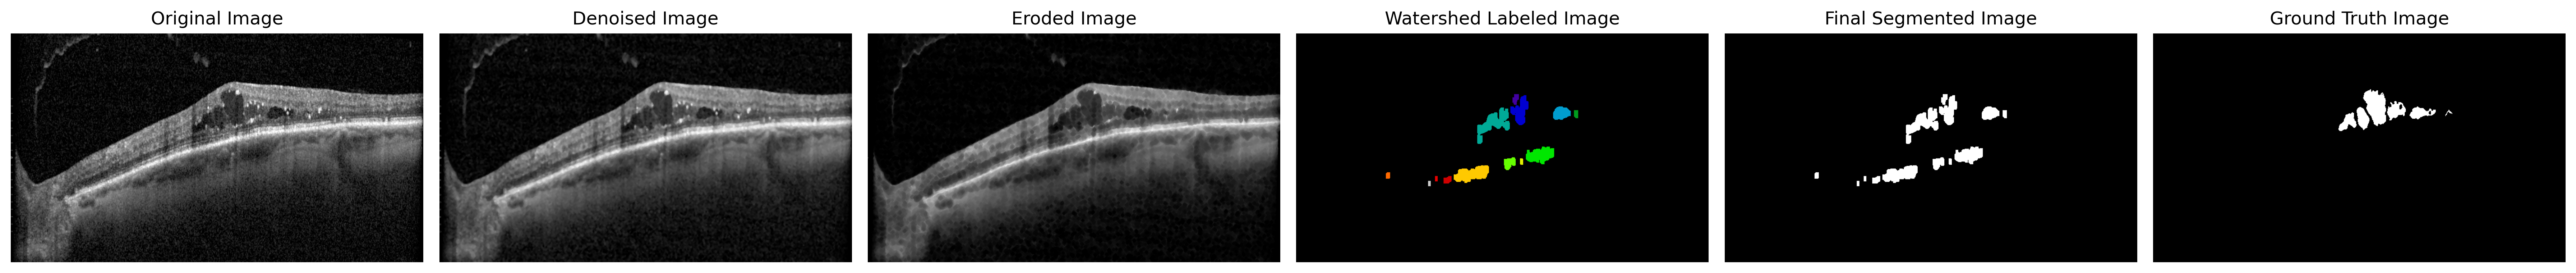

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.morphology import square,disk, erosion, opening, footprint_rectangle
from skimage import io, data, img_as_ubyte, img_as_float
from skimage.filters import rank, threshold_otsu, gaussian
from skimage.restoration import denoise_bilateral, denoise_nl_means,estimate_sigma
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import label, regionprops
from skimage.color import rgb2gray
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import convolve
from skimage.segmentation import clear_border
from google.colab import drive
import os


def load_oct_images():

    drive.mount('/content/drive')

    # Replace 'My Drive/your_folder' with the actual path to your folder in Google Drive
    input_folder_path = '/content/drive/My Drive/Colab_Notebooks/OCT_Dataset/img_dir'
    output_folder_path = '/content/drive/My Drive/Colab_Notebooks/OCT_Dataset/ann_dir'

    # List files in the specified folder
    try:
      input_image_list = sorted(os.listdir(input_folder_path))
      output_image_list = sorted(os.listdir(output_folder_path))
      #print(input_image_list)
      #print(output_image_list)
    except FileNotFoundError:
        print(f"Error: The folder '{input_folder_path}' or '{output_folder_path}' was not found.")
        return None, None, None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None, None

    return input_folder_path, output_folder_path, input_image_list, output_image_list

def select_image(input_folder_path, output_folder_path, input_image_list, output_image_list):
    all_ip_im = []
    all_op_im = []

    # Ensure both lists are not empty and have the same length
    if not input_image_list or not output_image_list or len(input_image_list) != len(output_image_list):
      print("Error: Image lists are empty or have different lengths.")
      return [], []

    for i in range(len(input_image_list)):
      try:
          ip_im_path = os.path.join(input_folder_path, input_image_list[i])
          op_im_path = os.path.join(output_folder_path, output_image_list[i])

          # Load input image
          ip_im = io.imread(ip_im_path)
          all_ip_im.append(ip_im)

          # Load output (annotated) image
          op_im = io.imread(op_im_path)
          all_op_im.append(op_im)

      except FileNotFoundError:
          print(f"Error: Image file not found at {ip_im_path} or {op_im_path}")
          continue
      except Exception as e:
          print(f"An error occurred while loading image {input_image_list[i]}: {e}")
          continue

    return all_ip_im, all_op_im

# Redefine a pre-processing function that does not plot
def pre_processing_for_loop(ip_im):
  im_denoised = rank.median(ip_im, disk(2.5))
  selem_radius = 2
  selem = disk(selem_radius)
  eroded_image = erosion(im_denoised, selem)
  return im_denoised, eroded_image

# The dice_index function from cell be82c30e is assumed to be defined and available.
# If not, it needs to be included here or re-executed from its original cell.
# For completeness, including it here:
def dice_index(image1, image2):
    image1_bool = image1 > 0
    image2_bool = image2 > 0
    intersection = np.logical_and(image1_bool, image2_bool).sum()
    sum_of_areas = image1_bool.sum() + image2_bool.sum()

    if sum_of_areas == 0:
        return np.nan
    else:
        return (2. * intersection) / sum_of_areas

def iou_metric(image1, image2):
    image1_bool = image1 > 0
    image2_bool = image2 > 0
    intersection = np.logical_and(image1_bool, image2_bool).sum()
    union = np.logical_or(image1_bool, image2_bool).sum()

    if union == 0:
        return np.nan
    else:
        return intersection / union

# START EXPLAINING HERE
# Initialize empty lists to store Dice coefficients and IoU values and intermediate images
dice_coefficients = []
iou_coefficients = []
all_denoised_images = []
all_eroded_images = []
all_segmented_images = []
all_labeled_cleared_images = [] # New list to store labeled_cleared images

input_folder_path, output_folder_path, input_image_list, output_image_list = load_oct_images()

all_ip_im, all_op_im = select_image(input_folder_path, output_folder_path, input_image_list, output_image_list)

print(f"Loaded {len(all_ip_im)} input images and {len(all_op_im)} annotated images.")

# Loop through each image pair
for i in range(len(all_ip_im)):
    ip_image = all_ip_im[i]
    op_image = all_op_im[i]

    print(f"Processing image {i+1}/{len(all_ip_im)}")

    # 3. Apply pre-processing
    im_denoised, eroded_image = pre_processing_for_loop(ip_image)
    all_denoised_images.append(im_denoised)
    all_eroded_images.append(eroded_image)

    # 4. Apply watershed segmentation steps
    # a. Generate background markers
    # Use eroded_image as the input for initial thresholding and binary image creation.
    if eroded_image.max() > 0:
        thresh_ws = threshold_otsu(eroded_image)
        binary_ws = eroded_image > thresh_ws
    else:
        # If eroded_image is all black, binary_ws will also be all black
        binary_ws = np.zeros_like(eroded_image, dtype=bool)

    binary_inverted_ws = ~binary_ws # Invert to get potential background regions as white
    # Use footprint_rectangle to address FutureWarning
    selem_ws = footprint_rectangle((10, 5))
    background_markers = opening(binary_inverted_ws, selem_ws)
    labeled_background = label(background_markers)

    # b. Clear regions touching the border
    labeled_cleared = clear_border(labeled_background)
    all_labeled_cleared_images.append(labeled_cleared) # Store labeled_cleared image

    # c. Filter by lower label values
    unique_labels = np.unique(labeled_cleared)
    non_zero_labels = unique_labels[unique_labels != 0]
    label_threshold = 20

    lower_labels_image = np.zeros_like(labeled_cleared, dtype=labeled_cleared.dtype)
    if non_zero_labels.size > 0:
        for label_value in non_zero_labels:
            if label_value <= label_threshold:
                lower_labels_image[labeled_cleared == label_value] = label_value
    binary_watershed_segmented_image = (lower_labels_image > 0).astype(np.uint8)
    all_segmented_images.append(binary_watershed_segmented_image)

    # 5. Calculate the Dice coefficient and IoU value
    # Convert 3-channel RGB annotated image to binary
    op_image_binary = (op_image > 0).any(axis=-1)

    current_dice = dice_index(binary_watershed_segmented_image, op_image_binary)
    dice_coefficients.append(current_dice)

    current_iou = iou_metric(binary_watershed_segmented_image, op_image_binary)
    iou_coefficients.append(current_iou)

# 6. Display individual Dice coefficients and IoU values (after the loop)
print("\nIndividual Image Metrics:")
for idx, (dice_val, iou_val) in enumerate(zip(dice_coefficients, iou_coefficients)):
    print(f"Image {idx+1}: Dice={dice_val:.4f}, IoU={iou_val:.4f}")

mean_dice = np.nanmean(dice_coefficients) # Use nanmean to handle potential NaN values
mean_iou = np.nanmean(iou_coefficients)

#calculate the std deviation
std_dice = np.nanstd(dice_coefficients)
std_iou = np.nanstd(iou_coefficients)

print(f"\nMean Dice Coefficient: {mean_dice:.4f}")
print(f"Standard Deviation of Dice Coefficient: {std_dice:.4f}")
print(f"Mean IoU Value: {mean_iou:.4f}")
print(f"Standard Deviation of IoU Value: {std_iou:.4f}")

print("Finished processing all images and calculating Dice and IoU coefficients.")

# Find the index of the lowest Dice coefficient
min_dice_index = 1#np.nanargmin(dice_coefficients)
lowest_dice_value =  dice_coefficients[min_dice_index]

print(f"\nImage with the lowest Dice Coefficient (Image {min_dice_index+1}): {lowest_dice_value:.4f}")

# Retrieve the corresponding images
original_image_lowest_dice = all_ip_im[min_dice_index]
denoised_image_lowest_dice = all_denoised_images[min_dice_index]
eroded_image_lowest_dice = all_eroded_images[min_dice_index]
labeled_cleared_image_lowest_dice = all_labeled_cleared_images[min_dice_index] # Retrieve labeled_cleared image
segmented_image_lowest_dice = all_segmented_images[min_dice_index]
ground_truth_image_lowest_dice = (all_op_im[min_dice_index] > 0).any(axis=-1)

# Display the images (now 6 subplots)
plt.figure(figsize=(24, 8), dpi=300) # Adjusted figure size for 6 plots

plt.subplot(1, 6, 1)
plt.imshow(original_image_lowest_dice, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 6, 2)
plt.imshow(denoised_image_lowest_dice, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')

plt.subplot(1, 6, 3)
plt.imshow(eroded_image_lowest_dice, cmap='gray')
plt.title('Eroded Image')
plt.axis('off')

plt.subplot(1, 6, 4) # New subplot for labeled_cleared image
plt.imshow(labeled_cleared_image_lowest_dice, cmap='nipy_spectral') # Use a colormap for labeled images
plt.title('Watershed Labeled Image')
plt.axis('off')

plt.subplot(1, 6, 5)
plt.imshow(segmented_image_lowest_dice, cmap='gray')
plt.title('Final Segmented Image')
plt.axis('off')

plt.subplot(1, 6, 6)
plt.imshow(ground_truth_image_lowest_dice, cmap='gray')
plt.title('Ground Truth Image')
plt.axis('off')

plt.tight_layout()
plt.show()